<h6 style="margin-bottom: 0px" align="center">
    <div>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ ФЕДЕРАЛЬНОЕ</div> 
    <div>ГОСУДАРСТВЕННОЕ АВТОНОМНОЕ ОБРАЗОВАТЕЛЬНОЕ</div>
    <div>УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ</div>
</h6>
<h5 style="margin-top: 0px" align="center">Национальный исследовательский ядерный университет «МИФИ»</h5>

<div style="border: 1px solid black;"></div>

<h2 align="center">
    <div>Институт</div> 
    <div>интеллектуальных кибернетических систем</div>
    <div>Кафедра №22 «Кибернетика»</div>
</h2>

<div align="center">Направление подготовки 09.03.04 Программная инженерия</div>

<h1 align="center">Лабораторная работа №4</h1>
<div align="center">
    по дисциплине:
    «Обработка аудио-визуальной информации»
</div>
<div align="center">
    На тему: «Признаки»
</div>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border: 1px solid black;}
.tg .tg-0pky{border: 1px solid black;}
</style>
<table class="tg">
<tbody>
  <tr>
    <td class="tg-0pky">Группа</td>
    <td class="tg-0pky">М20-504</td>
  </tr>
  <tr>
    <td class="tg-0pky">Студент</td>
    <td class="tg-0pky">Григорьев А.А.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Преподаватель</td>
    <td class="tg-0pky">Демидов Д.В.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Оценка</td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Подпись</td>
    <td class="tg-0pky"></td>
  </tr>
</tbody>
</table>

<div style="page-break-before: always;"></div>

# 1. Генерация изображений символов

In [10]:
import string
from PIL import Image, ImageFont, ImageDraw
import os
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.display import HTML, display as disp
import numpy
import base64
from io import BytesIO

def img_to_base64(img, format="PNG"):
    buffered = BytesIO()
    img.save(buffered, format=format)
    return base64.b64encode(buffered.getvalue())

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(100,100), cmap='gray'):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i], cmap=cmap)
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])


def grid_display_html(list_of_images, make_src=True):
    html = ''
    for image in list_of_images:
        if make_src:
            b64 = img_to_base64(image)
            src=f"data:image/png;base64, {b64}"
        else:
            src = image
        html += f'<span style="border: 1px solid black; padding: 2px;"><img src="{src}"/></span>'
    disp(HTML(html))
    # return html

letters = list(string.ascii_lowercase) + list(string.ascii_uppercase)

fonts = []

font_types = os.listdir('./fonts/')
for font_type in font_types:
    fonts += [
        {
            'name':font_file[:-4], 
            'path': os.path.join('./fonts/', font_type, font_file)
        } 
        for font_file in os.listdir(os.path.join('./fonts/', font_type)) 
        if '.ttf' in font_file
    ]

def add_border(img):
    matrix = numpy.matrix(img)
    matrix = numpy.append(matrix, numpy.zeros((matrix.shape[0], 1), dtype="uint8"), axis=1)
    matrix = numpy.append(numpy.zeros((matrix.shape[0], 1), dtype="uint8"), matrix, axis=1)
    matrix = numpy.append(matrix, numpy.zeros((1, matrix.shape[1]), dtype="uint8"), axis=0)
    matrix = numpy.append(numpy.zeros((1, matrix.shape[1]), dtype="uint8"), matrix, axis=0)
    return Image.fromarray(numpy.asarray(matrix, dtype="uint8"), "L")

for letter in letters:
    for font in fonts:
        fl_images = []
        max_size = [0, 0]
        for font_size in [12, 14, 16, 22, 28, 36, 48]:
            f = ImageFont.truetype(font['path'], size=font_size)
            w, h = f.getsize(letter)
            if (w > max_size[0]):
                max_size[0] = w
            if (h > max_size[1]):
                max_size[1] = h
            image = Image.new('L', (w, h), 255)
            draw = ImageDraw.Draw(image)
            draw.text((0,0), letter, 0, f)
            save_path = os.path.join('./src/', f'{letter}_{font["name"]}_{font_size}.bmp')
            image.save(save_path)
            fl_images.append(add_border(image))
print('Пример', letter, font['name'])
grid_display(fl_images, figsize=(50, 50), no_of_columns=len(fl_images))




Пример Z gomarice_font_yaki_goma


# 2. Расчет признаков
## 2.1. Реализация

In [11]:
class ImageProcessor:
    @staticmethod
    def cut_letter(img: Image.Image): # обрезка белых краев изображения буквы
        matrix = numpy.matrix(img)
        filter = []
        for index, row in enumerate(matrix):
            if numpy.all(row > 127):
                filter.append(index)
            else:
                break
        for index, row in reversed(list(enumerate(matrix))):
            if numpy.all(row > 127):
                filter.append(index)
            else:
                break
        filter = sorted(filter)
        matrix = numpy.delete(matrix, filter, axis = 0)
        matrix = numpy.matrix(numpy.asarray(matrix)).transpose()
        filter = []
        for index, row in enumerate(matrix):
            if numpy.all(row > 127):
                filter.append(index)
            else:
                break
        for index, row in reversed(list(enumerate(matrix))):
            if numpy.all(row > 127):
                filter.append(index)
            else:
                break
        filter = sorted(filter)
        matrix = numpy.delete(matrix, filter, axis = 0)
        matrix = numpy.matrix(numpy.asarray(matrix)).transpose()
        
        return matrix

    @staticmethod
    def weights(matrix): # вес черного и удельный вес черного
        array = numpy.array(matrix).flatten()
        f = numpy.where(array < 127)
        weight = f[0].size
        return weight, float(weight) / (matrix.shape[0] * matrix.shape[1])

    @staticmethod
    def center_coords(matrix): # координаты центра тяжести и нормированные координаты центра тяжести
        matrix = numpy.asarray(matrix)
        width, height = matrix.shape
        weight, density = ImageProcessor.weights(matrix)

        x_center = 0
        found = False
        for i in range(width):
            for j in range(height):
                x_center += i * matrix[i, j] < 127
                if x_center * 2 > weight:
                    x_center = i
                    found = True
                    break
            if found:
                break

        found = False
        y_center = 0
        for j in range(height):
            for i in range(width):
                y_center += j * matrix[i, j] < 127
                if y_center * 2 > weight:
                    y_center = j
                    found = True
                    break
            if found:
                break

        return x_center, y_center, float(x_center) / width * 100, float(y_center) / height * 100

                    

    @staticmethod
    def moments(matrix): # осевые моменты инерции и нормированные осевые моменты инерции
        width, height = matrix.shape
        x_center, y_center, norm_x, norm_y = ImageProcessor.center_coords(matrix)

        x_moment = numpy.sum([
            (i - x_center) ** 2 
            for i in range(width) 
            for j in range(height) 
            if matrix[i, j] < 127
        ])
        y_moment = numpy.sum([
            (i - y_center) ** 2 
            for i in range(height) 
            for j in range(width) 
            if matrix[j, i] < 127
        ])
        z_moment = numpy.sum([
            (i - x_center) ** 2 + (j - y_center) ** 2 
            for i in range(width) 
            for j in range(height) 
            if matrix[i, j] < 127
        ])

        x_moment_norm = float(x_moment) / z_moment * 100
        y_moment_norm = float(y_moment) / z_moment * 100

        return x_moment, y_moment, x_moment_norm, y_moment_norm

    @staticmethod
    def profiles(matrix, draw_plot=True): # профили
        matrix = numpy.asarray(matrix < 127, dtype="uint8")
        vertical_profile_x = numpy.arange(start=1, stop=matrix.shape[1] + 1).astype(int)
        vertical_profile_y = numpy.sum(matrix, axis=0)

        horizontal_profile_x = numpy.arange(start=1, stop=matrix.shape[0] + 1).astype(int)
        horizontal_profile_y = numpy.sum(matrix, axis=1)

        if draw_plot:
            plt.bar(x=vertical_profile_x, height=vertical_profile_y)
            plt.show()
            plt.barh(y=horizontal_profile_x, width=horizontal_profile_y)
            plt.show()

        return vertical_profile_x, vertical_profile_y, horizontal_profile_x, horizontal_profile_y


## 2.2. Результаты

Расчет будем производить для шрифта `gomarice_font_yaki_goma` 48 размера

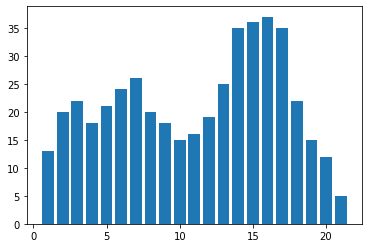

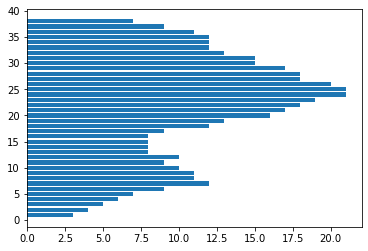

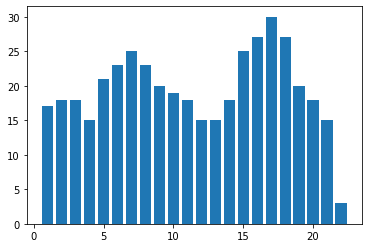

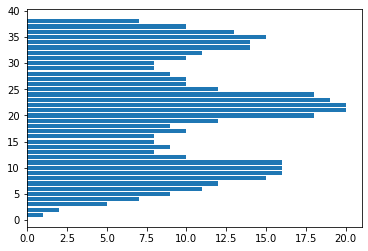

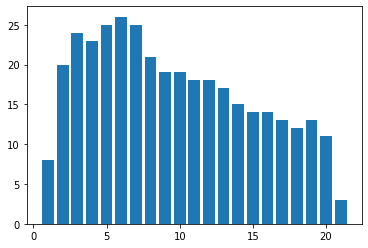

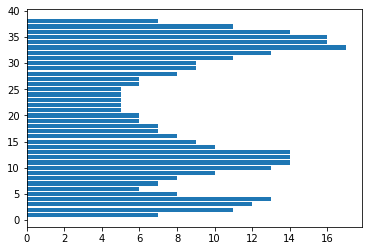

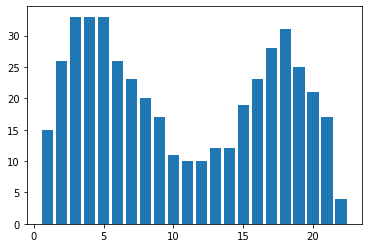

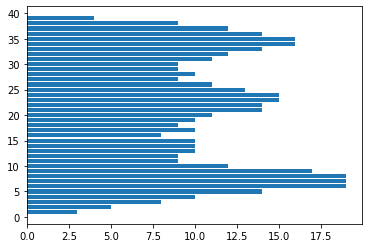

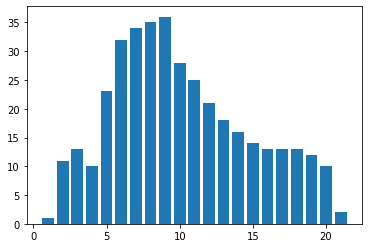

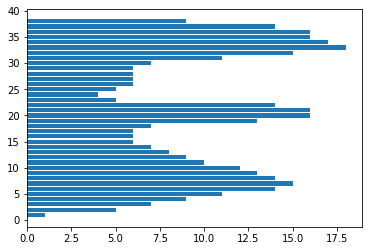

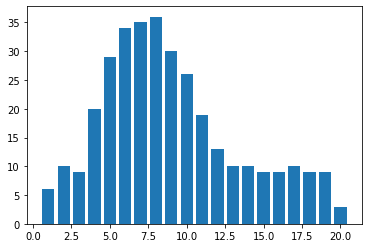

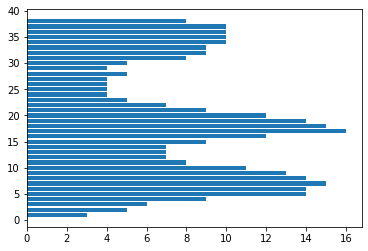

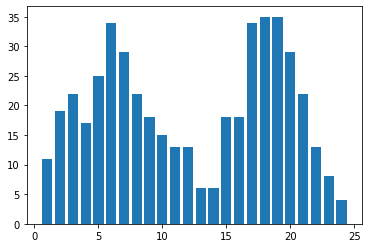

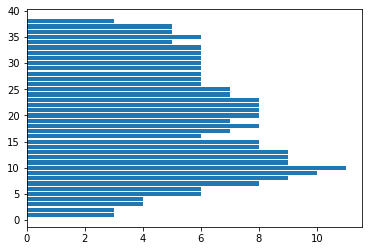

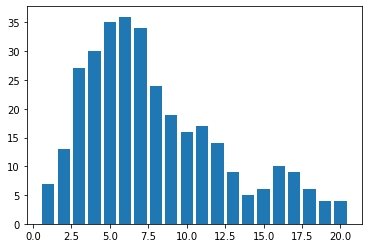

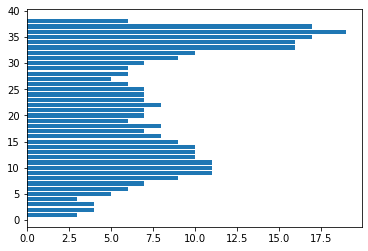

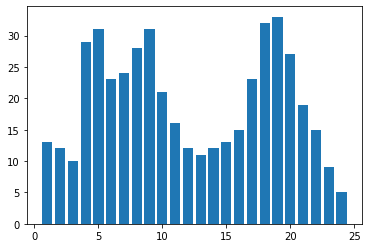

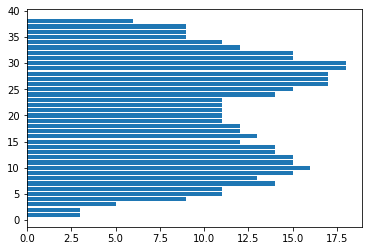

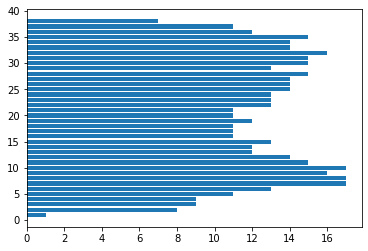

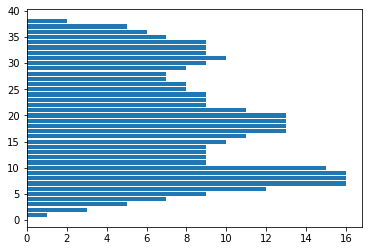

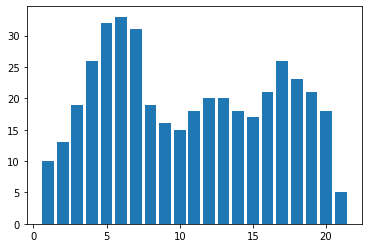

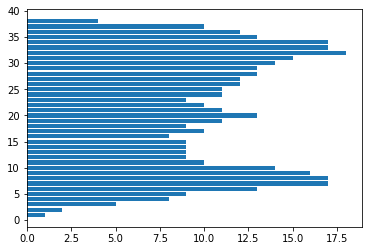

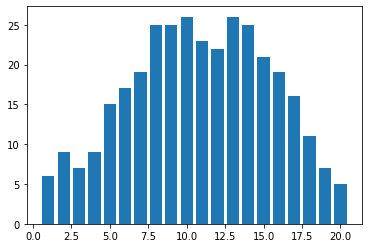

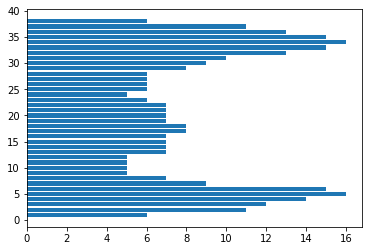

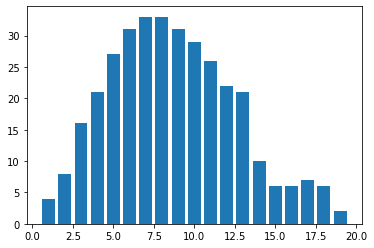

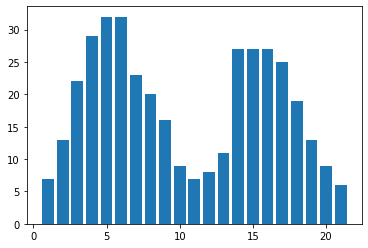

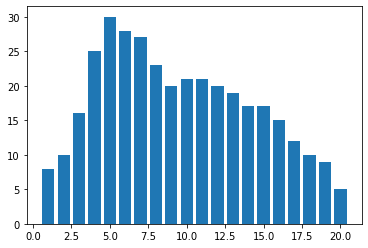

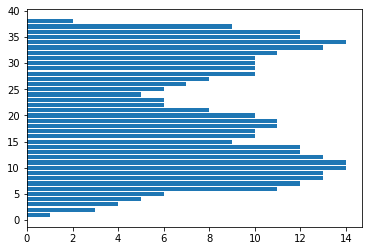

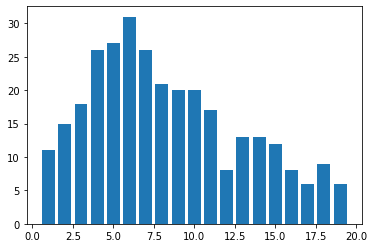

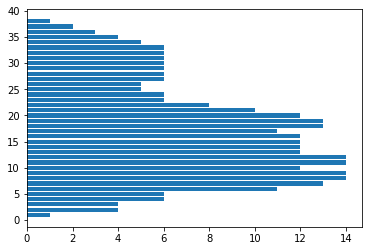

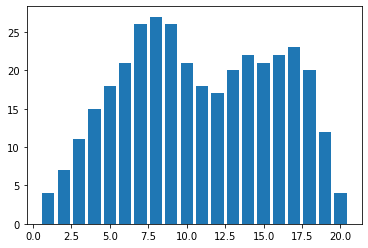

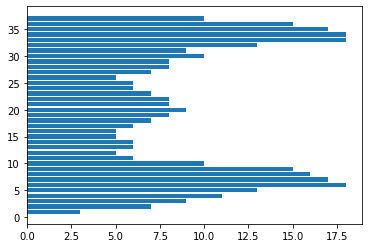

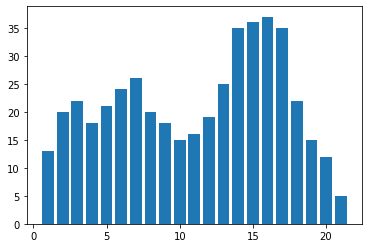

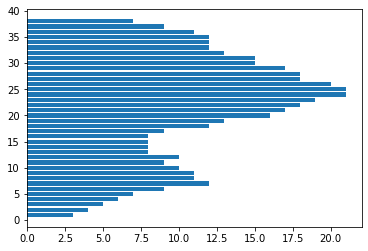

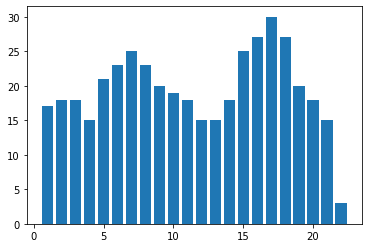

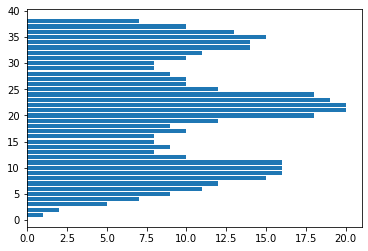

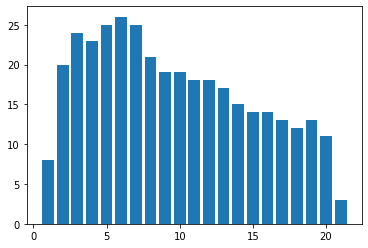

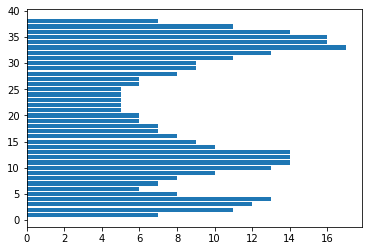

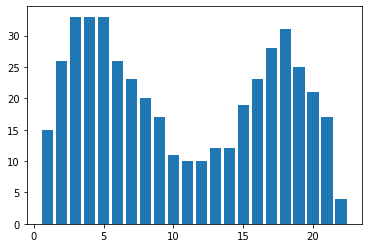

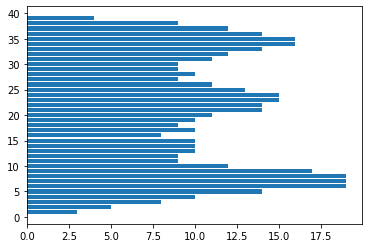

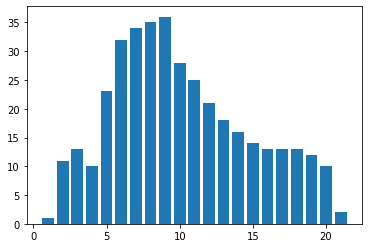

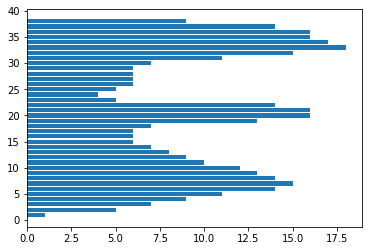

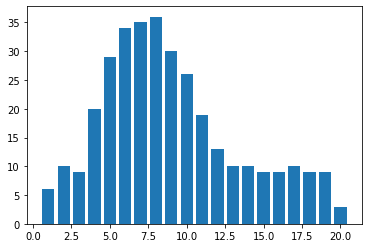

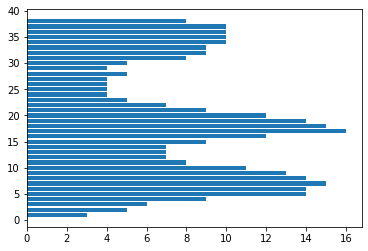

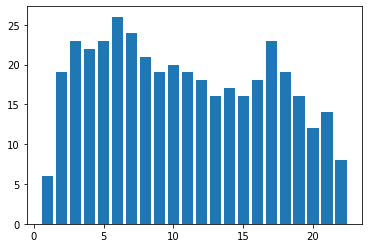

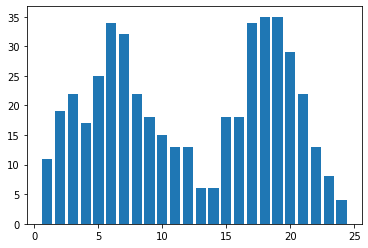

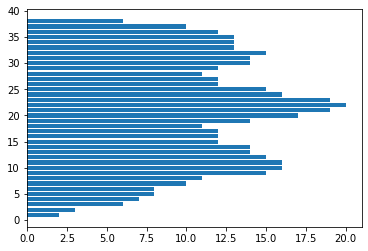

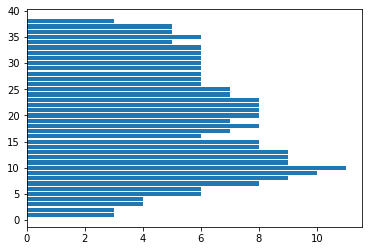

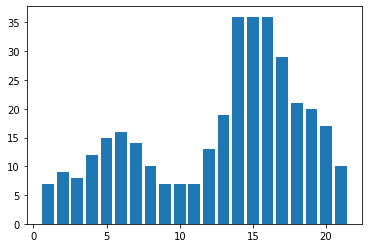

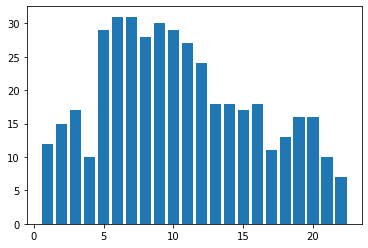

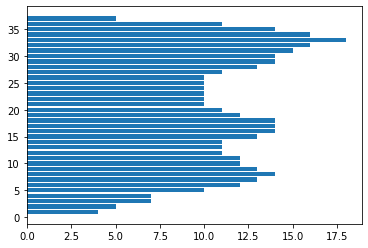

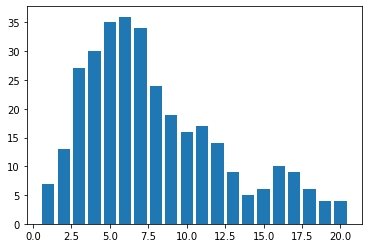

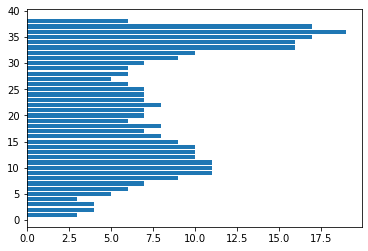

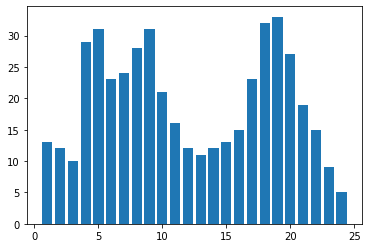

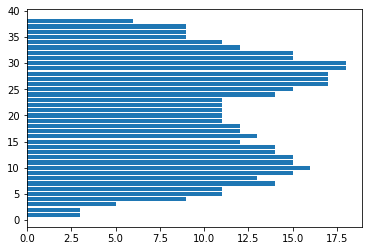

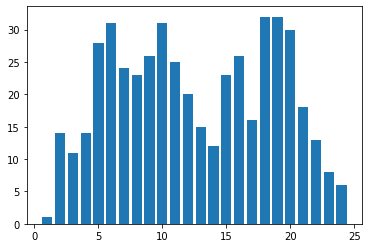

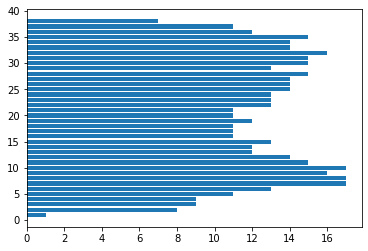

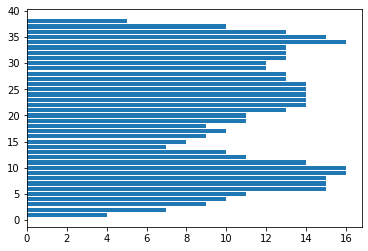

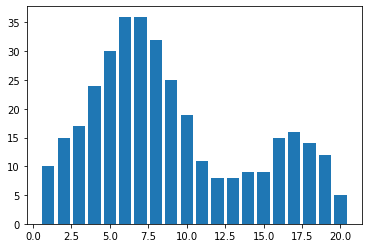

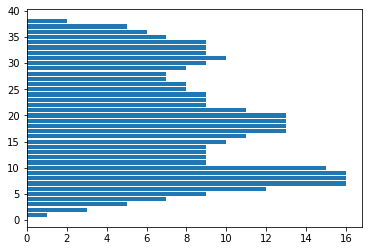

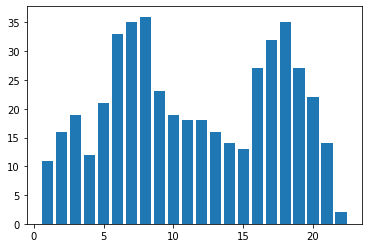

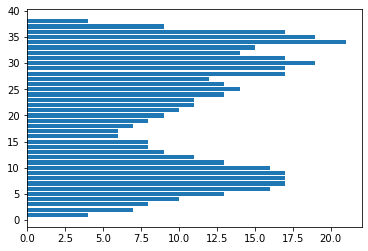

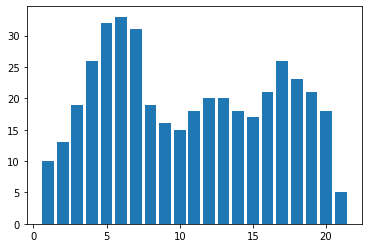

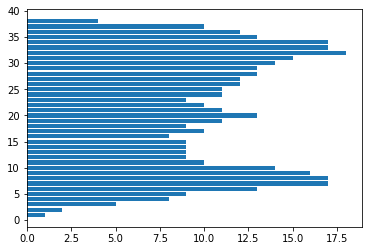

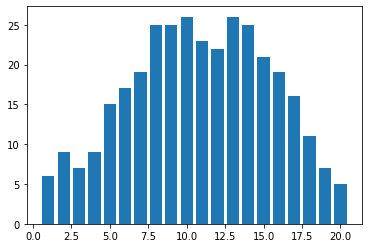

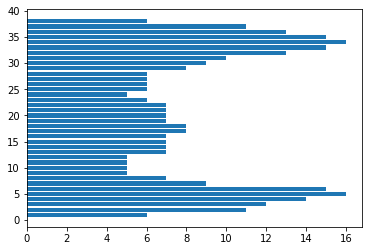

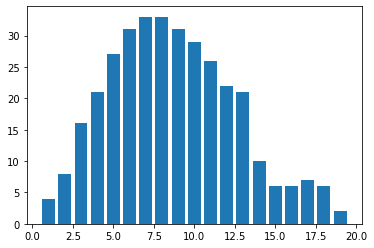

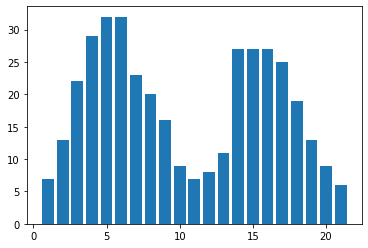

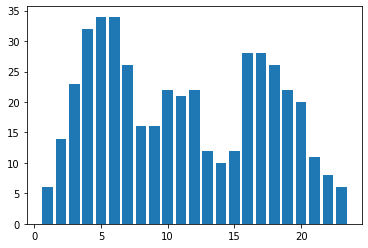

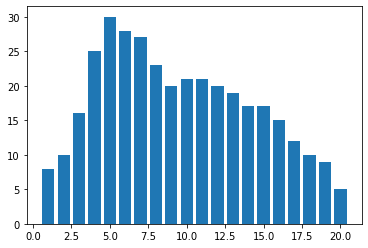

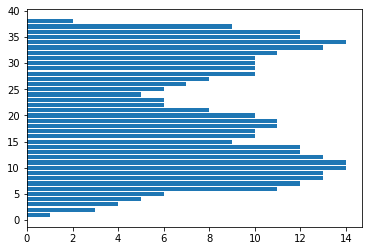

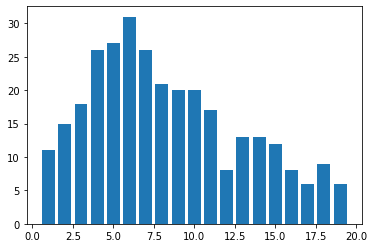

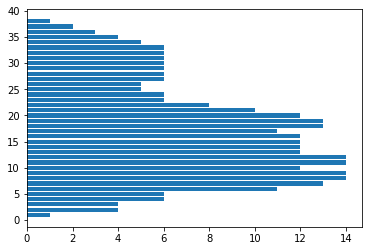

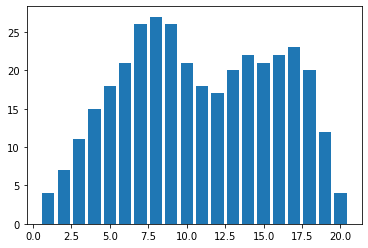

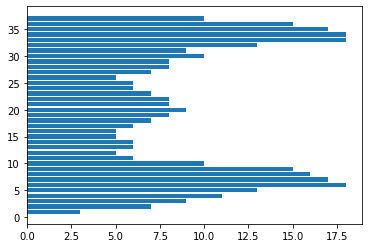

In [12]:
import csv

font_name = fonts[-1]['name']
font_size = 48

features = {}

for letter in letters:
    path = os.path.join('./src/', f'{letter}_{font_name}_{font_size}.bmp')
    img = Image.open(path).convert('L')
    matrix = ImageProcessor.cut_letter(img)
    
    width, height = matrix.shape
    weight, unit_weight = ImageProcessor.weights(matrix)
    x_center, y_center, x_norm, y_norm = ImageProcessor.center_coords(matrix)
    
    features[letter] = {
        'matrix': matrix,
        'letter': letter,
        'file': path,
        'font': font_name,
        'size': font_size,
        'width': width,
        'height': height,
        'weight': weight,
        'unit_weight': unit_weight,
        'x_center': x_center,
        'y_center': y_center,
        'x_norm': x_norm,
        'y_norm': y_norm
    }
    cutted = Image.fromarray(numpy.asarray(matrix, dtype = 'uint8'), 'L')
    
    rows = "</tr><tr>".join([
                f"<td style=\"border: 1px solid black;\">{key}</td><td style=\"border: 1px solid black;\">{features[letter][key]}</td>"
                for key in features[letter]
                if key != "matrix"
            ])
    html = f'''
        <table>
            <tr>{rows}</tr>
        </table>
    '''
    display(add_border(cutted))
    a,b,c,d = ImageProcessor.profiles(matrix)
    disp(HTML(html))

file = open('./data.csv', "w")
writer = csv.writer(file)
writer.writerows([[key for key in features[letter] if key != 'matrix']] + [
    [
        features[letter][key] 
        for key in features[letter] if key != 'matrix'
    ]
    for letter in features
])
file.close()

    


Данные для указанного шрифта и размера сохранены в csv файл